# Классификация древних языков с помощью Resnet-50



In [ ]:
import os
#import numpy as np
from google.colab import files
from fastai import *
from fastai.vision import *
import statistics
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Загрузка данных

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ancient.zip to ancient (1).zip


In [ ]:
!unzip "ancient (1).zip"

Archive:  ancient (1).zip
  inflating: ancient_language_dataset/test/arabic/24dca116894a4de7e530f7f7ffdf5cea--islamic-images-arabic-beauty.jpg  
  inflating: ancient_language_dataset/test/arabic/Calligraphy-Arabic-Font161-min.jpg  
  inflating: ancient_language_dataset/test/arabic/Khirbet-Inscription-Hisham.jpg  
  inflating: ancient_language_dataset/test/arabic/MalDia-04-10-08-16-Abate-Vella-claimed-to-have-discovered-ancient-Arabic-parchments.-751x1024.jpg  
  inflating: ancient_language_dataset/test/arabic/Writing-style-follow-by-Arabic-Script_Q320.jpg  
  inflating: ancient_language_dataset/test/arabic/a31224b.jpg  
  inflating: ancient_language_dataset/test/arabic/epigraphy_ambalangoda_port_des_01.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-183578917-612x612.jpg  
  inflating: ancient_language_dataset/test/arabic/istockphoto-644911038-1024x1024.jpg  
  inflating: ancient_language_dataset/test/egyptian/124388-004-686BFFFF.jpg  
  inflating: ancient_language_

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 6.6 kB/s 
     |████████████████████████████████| 4.0 MB 40.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.4.0 which is incompatible.


### Обучение нейросети

Количество обучающих примеров за одну итерацию - 16

In [ ]:
bs=16
np.random.seed(2)
os.chdir('/content')

In [ ]:
data_path = "./ancient_language_dataset/"
data = ImageDataBunch.from_folder(data_path, ds_tfms=get_transforms(), size=299, bs=bs, num_workers=0).normalize(imagenet_stats)

Изображения из датасета

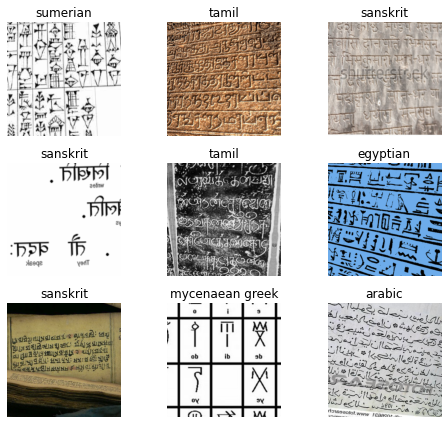

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
data.classes

['arabic',
 'egyptian',
 'latin',
 'mycenaean greek',
 'old_chinese',
 'sanskrit',
 'sumerian',
 'tamil']

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, path=".")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(14)

epoch,train_loss,valid_loss,accuracy,time
0,2.573975,1.434949,0.584615,00:31
1,1.805922,1.121211,0.661538,00:18
2,1.487994,1.481903,0.615385,00:18
3,1.214990,1.738462,0.630769,00:18
4,1.016800,1.113564,0.738462,00:18
5,0.866817,1.086877,0.723077,00:18
6,0.717930,0.999295,0.723077,00:18
7,0.606658,0.914175,0.707692,00:18
8,0.533139,0.888741,0.769231,00:18
9,0.487316,0.982521,0.723077,00:17


In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
___________________________________________________

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


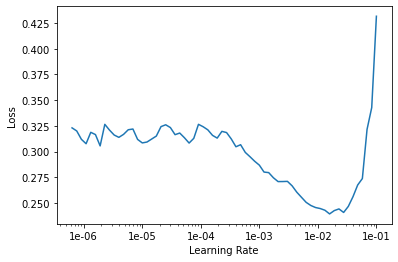

In [ ]:
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(9,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.291372,0.882050,0.753846,00:25
1,0.219492,0.921695,0.753846,00:21
2,0.200763,1.013641,0.769231,00:20
3,0.169274,0.967089,0.738462,00:21
4,0.190172,0.942333,0.753846,00:21
5,0.154025,0.901254,0.784615,00:21
6,0.140214,0.890663,0.800000,00:21
7,0.143511,0.875212,0.815385,00:21
8,0.153046,0.867758,0.815385,00:20


In [ ]:
learn.fit_one_cycle(1,max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.114282,0.857114,0.830769,00:21


In [ ]:
learn.save('stage-3-50')

In [ ]:
learn.load('stage-2-50')

Learner(data=ImageDataBunch;

Train: LabelList (253 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
sanskrit,sanskrit,sanskrit,sanskrit,sanskrit
Path: ancient_language_dataset;

Valid: LabelList (65 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
sanskrit,sanskrit,sanskrit,sanskrit,sanskrit
Path: ancient_language_dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
import torch
torch.cuda.empty_cache()

### Результаты

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

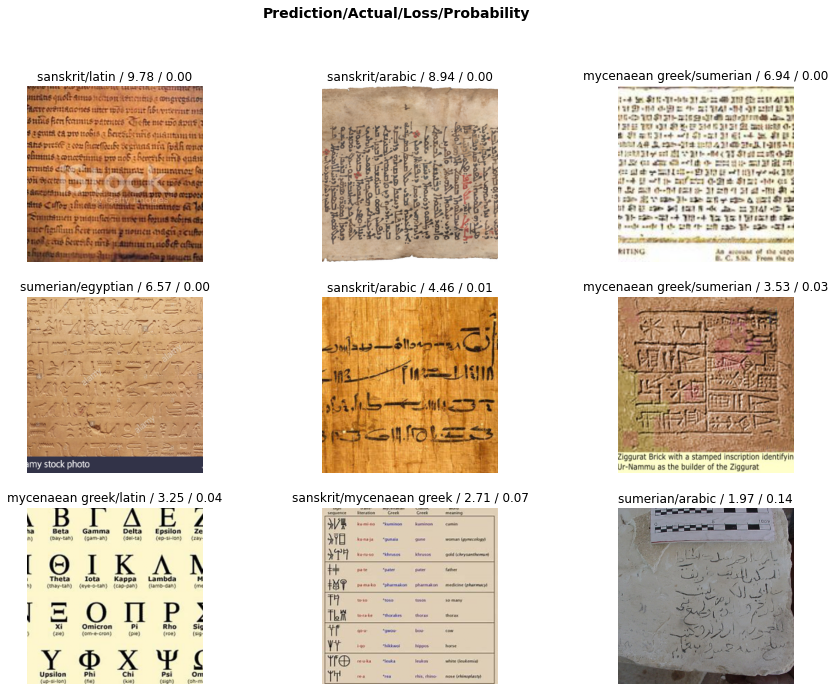

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

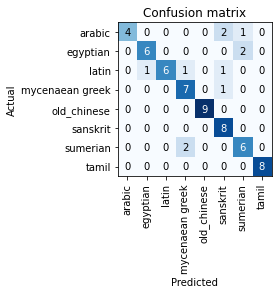

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=1)

[('arabic', 'sanskrit', 2),
 ('egyptian', 'sumerian', 2),
 ('sumerian', 'mycenaean greek', 2),
 ('arabic', 'sumerian', 1),
 ('latin', 'egyptian', 1),
 ('latin', 'mycenaean greek', 1),
 ('latin', 'sanskrit', 1),
 ('mycenaean greek', 'sanskrit', 1)]

In [ ]:
precision = 0
recall = 0
for i in range(0, 7):
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[i][j]
  precision_i = interp.confusion_matrix()[i][i] / s
  precision += precision_i
  s = 0
  for j in range(0, 7):
    s += interp.confusion_matrix()[j][i]
  recall_i = interp.confusion_matrix()[i][i] / s
  recall += recall_i

precision = precision / 8
recall = recall / 8
print(precision, recall)

0.7016369047619048 0.7363095238095239


In [ ]:
f1score = 2 * (precision * recall) / (precision + recall)
f1score

0.7185551908852127

In [ ]:
num = 0
denom = 0
for i in range(0, 7):
  num += interp.confusion_matrix()[i][i]
  for j in range(0, 7):
    denom += interp.confusion_matrix()[i][j]

acc = num / denom
acc

0.8070175438596491